In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from utils import *
from scipy.integrate import simpson

In [2]:
# lmbda_1 = 474 * 1e-9
lmbda_1 = 795 * 1e-9
# lmbda_1 = 948 * 1e-9

r_1 = 1e3
r_2 = 230 * 1e-3

a = 4.5 * 1e-3 / 2

k = 2 * np.pi / lmbda_1

### PARAMETERS ###

### MIRRORS ###
R_1 = 0.9999
R_2 = 0.9999

l = 0.16853
l

0.16853

In [3]:
g_1 = g(l, r_1)
g_2 = g(l, r_2)

Frensel_n = N(a, l, lmbda_1) 

w2 = mirror_1(g_1, g_2, l, lmbda_1) * 3
Frensel_n


37.7851096439915

C:\Users\Daniil\AppData\Local\Temp\ipykernel_19392\3212516376.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x2*1e3, y2*1e3, U)


Text(0, 0.5, 'y, mm')

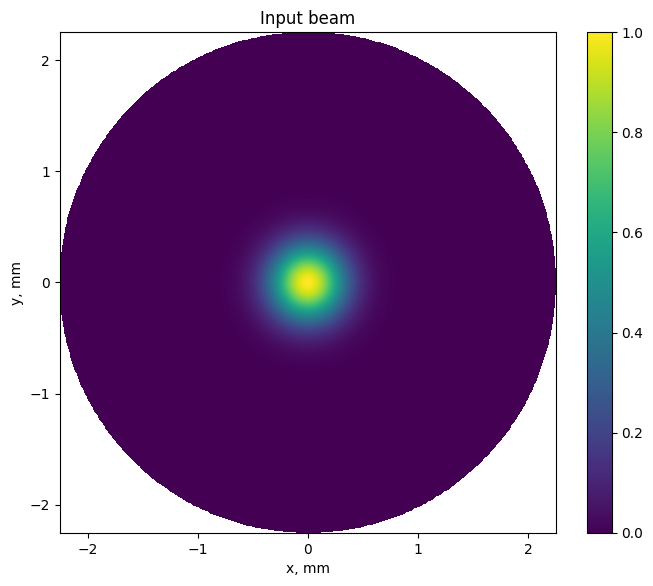

In [4]:
# w = 0.5
n = 0
m = 0

dx_count = 500
iters = 500
tilt_delta = 0
d_r = l * tilt_delta / a

rho_2 = np.linspace(0, a, dx_count)
phi_2 = np.linspace(0, 2.01*np.pi, dx_count)

rho_m = np.linspace(0, a*100, dx_count)
phi_m = np.linspace(0, 2.01*np.pi, dx_count)

PHI_2, RHO_2 = np.meshgrid(phi_2, rho_2)
PHI_M, RHO_M = np.meshgrid(phi_m, rho_m)
x2 = RHO_2 * np.cos(PHI_2)
y2 = RHO_2 * np.sin(PHI_2)


rho_1 = np.linspace(0, a, dx_count)
phi_1 = np.linspace(0, 2.01*np.pi, dx_count)

RHO_1, PHI_1 = np.meshgrid(rho_1, phi_1)
x1 = RHO_1 * np.cos(PHI_1)
y1 = RHO_1 * np.sin(PHI_1)

U = np.abs(LG_beam_far(RHO_2, PHI_2, w2, n, m))**2

plt.figure(figsize=(8, 6.5), dpi=100, facecolor='w', edgecolor='k')
plt.pcolormesh(x2*1e3, y2*1e3, U)
plt.colorbar()
plt.title('Input beam')
plt.xlabel('x, mm')
plt.ylabel('y, mm')

In [5]:
R_i_left = np.zeros((dx_count, iters+1), dtype=complex)
R_i_right = np.zeros((dx_count, iters), dtype=complex)

gamma_i_left = np.zeros((iters))
gamma_i_right = np.zeros((iters))

R_i_left[:,0] = LG_beam_far(rho_2, 0, w2, n, m)

In [6]:
I_l = np.zeros(len(rho_1), dtype=complex)
I_r = np.zeros(len(rho_2), dtype=complex)

def calc():
    for j in range(iters):
        for ss in range(len(rho_2)):
            I_r[ss] = simpson(func_2(rho_2[ss], rho_1, k, l,
                              g_1, R_i_left[:, j], n, tilt_delta, a), rho_1)

        R_i_right[:, j] = 1j**(n+1) * k / l * \
            np.exp(-1j*k / (2*l)*g_2*rho_2**2) * I_r
        gamma_i_right[j] = simpson(np.abs(R_i_right[:, j])**2, rho_2)
        R_i_right[:, j] /= np.max(np.abs(R_i_right[:, j]))

        for ii in range(len(rho_1)):
            I_l[ii] = simpson(func_1(rho_2, rho_1[ii], k, l,
                              g_2, R_i_right[:, j], n), rho_2)

        R_i_left[:, j+1] = 1j**(n+1) * k / l * \
            np.exp(-1j*k/(2*l)*g_1*(rho_1+d_r)**2) * I_l
        gamma_i_left[j] = simpson(np.abs(R_i_left[:, j+1])**2, rho_1)
        R_i_left[:, j+1] /= np.max(np.abs(R_i_left[:, j+1]))
    return R_i_right, R_i_left, gamma_i_right, gamma_i_left


R_i_right, R_i_left, gamma_i_right, gamma_i_left = calc()

C:\Users\Daniil\AppData\Local\Temp\ipykernel_19392\3070756850.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x1*1e3, y1*1e3, np.abs(E_1)**2)


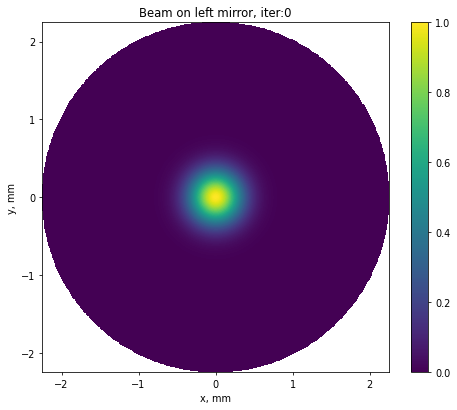

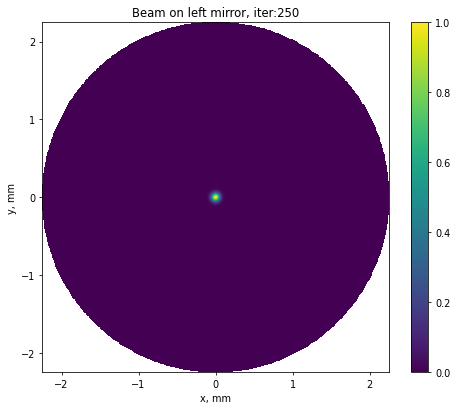

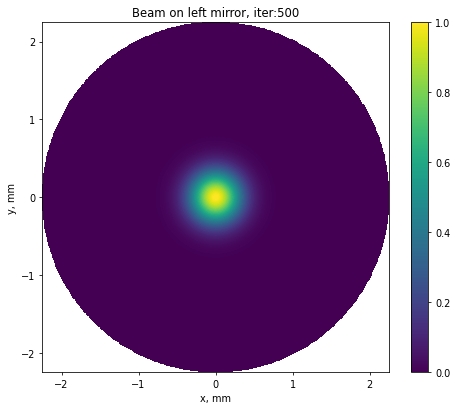

In [7]:
for indx in range(0, iters+1, 250):
    E_1 = R_i_left[:, indx] * np.exp(1j*n*PHI_1)
    plt.figure(figsize=(8, 6.5), dpi=70, facecolor='w', edgecolor='k')
    plt.pcolormesh(x1*1e3, y1*1e3, np.abs(E_1)**2)
    plt.colorbar()
    plt.title('Beam on left mirror, iter:' + str(indx))
    plt.xlabel('x, mm')
    plt.ylabel('y, mm')
    # plt.savefig('figs/'+str(indx)+'.png', format='png')


In [8]:
print('Losses:')
loss_l = gamma_i_left[10:]
loss_r = gamma_i_right[10:]
print('mean l', np.mean(loss_l))
print('mean r', np.mean(loss_r))
print('std l', np.std(loss_l))
print('std r', np.std(loss_r))
losses_difr = (1 - np.mean(loss_l)) * \
    (1 - np.mean(loss_r))
print()
print('Total difr losses:', np.round(1-losses_difr, 6))

Losses:
mean l 0.0015805446940134512
mean r 0.00021900719762232488
std l 0.001880915659342529
std r 0.00026084205879195764

Total difr losses: 0.001799


In [9]:
gamma = - np.log(R_1*R_2*(losses_difr))
losses_total = R_1*R_2*losses_difr
finesse = np.pi / np.arcsin((1 - np.sqrt(losses_total))/(2*losses_total**(1/4))) / 2
finesse = 2 * np.pi / gamma
finesse

3140.279614223331

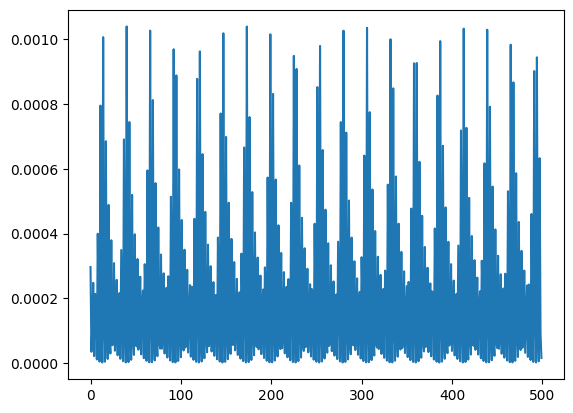

In [10]:
plt.plot(gamma_i_right)

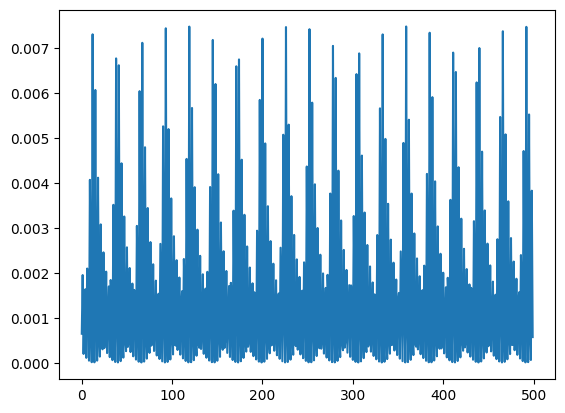

In [11]:
plt.plot(gamma_i_left)

In [12]:
def power(my_list):
    return [x**(1/4) for x in my_list]

array_of_losses = [0.00014845398197294024,
                   0.00017348483033985396, 0.00019182611744517075, 0.00021195313487254452, 0.00023635715499326082, 0.0002703517059841065,
                   0.0003223840676503942, 0.0004191854456462307, 0.0006644331006002702, 0.003686793940697153]


### 474 nm ###
# [0.00022, 0.000247, 0.000272]
# [0.00014845398197294024,
#                    0.00017348483033985396, 0.00019182611744517075, 0.00021195313487254452, 0.00023635715499326082, 0.0002703517059841065,
#                    0.0003223840676503942, 0.0004191854456462307, 0.0006644331006002702, 0.003686793940697153]
array_of_losses_tilt = [0.0001747685792985454,
                        0.00025629130957549595, 0.0003220559569794279, 0.00028551117319652874, 0.0004397569120189182, 0.0003711849644782994,
                        0.00036496808122543634, 0.0005386496355775927, 0.0011534041769346581, 0.013235706061376029]
array_of_l = np.linspace(0.1, 0.99, 11)[1:] * 23

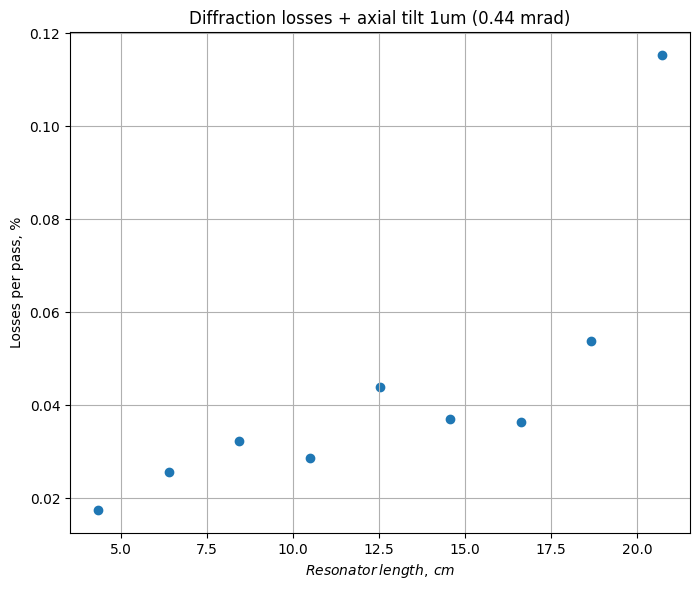

In [13]:

plt.figure(figsize=(8, 6.5), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(array_of_l[:-1], np.asarray(array_of_losses_tilt[:-1])*100)
plt.title('Diffraction losses + axial tilt 1um (0.44 mrad)')
plt.xlabel('$Resonator \: length, \: cm$')
plt.ylabel('Losses per pass, %')
plt.grid()

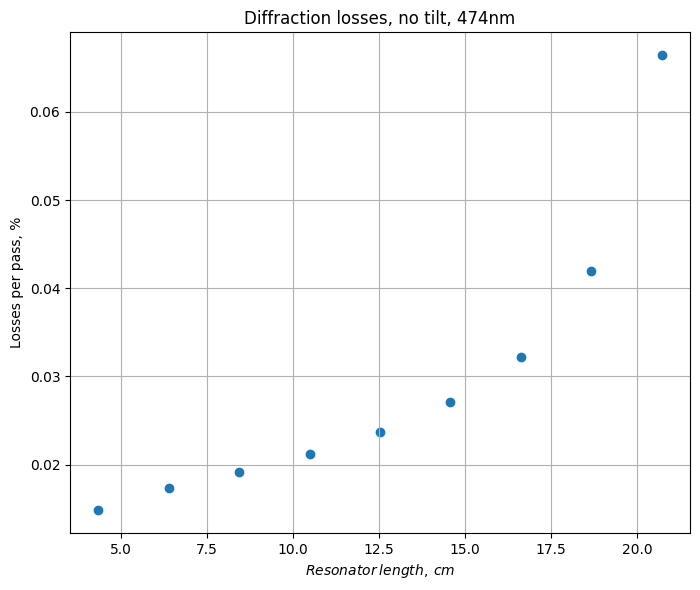

In [14]:
plt.figure(figsize=(8, 6.5), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(array_of_l[:-1], np.asarray(array_of_losses[:-1])*100)
plt.title('Diffraction losses, no tilt, 474nm')
plt.xlabel('$Resonator \: length, \: cm$')
plt.ylabel('Losses per pass, %')
plt.grid()


In [15]:
array_of_l / 23

array([0.189, 0.278, 0.367, 0.456, 0.545, 0.634, 0.723, 0.812, 0.901,
       0.99 ])